In [22]:
import pandas as pd
import numpy as np
import os
import random
import typing
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [23]:
DATA_PATH = 'data_cars/'
# all_files = os.listdir(DATA_PATH)
all_files = ['K120.csv', 'K140.csv', 'K159.csv', 'K405.csv', 'K406.csv', 'K701.csv', 'K703.csv', 'K709.csv']
print(all_files)

['K120.csv', 'K140.csv', 'K159.csv', 'K405.csv', 'K406.csv', 'K701.csv', 'K703.csv', 'K709.csv']


In [24]:
bad_files = [x for x in os.listdir(DATA_PATH) if x not in all_files]
print(bad_files)

all_dataframes = []
for index, file in enumerate(os.listdir(DATA_PATH)):
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    all_dataframes.append(df)
    # print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
# combined_df.fillna(method='ffill', inplace=True)
print("na: " ,combined_df.isna().sum().sum())
# combined_df.interpolate(method='linear', inplace=True, limit=3)
# combined_df['hour'] = combined_df.index.hour
# combined_df['day_of_week'] = combined_df.index.dayofweek

# combined_df = combined_df[:]
# print(combined_df)
# print(all_dataframes)
# print(combined_df.isnull().sum().sum())

data = np.array(combined_df, dtype=float)[:, :]
print(data.shape)

sensor_data = np.transpose(data)




['K134.csv', 'K702.csv', 'K711.csv']
Reading file: K120.csv
Reading file: K134.csv
Reading file: K140.csv
Reading file: K159.csv
Reading file: K405.csv
Reading file: K406.csv
Reading file: K701.csv
Reading file: K702.csv
Reading file: K703.csv
Reading file: K709.csv
Reading file: K711.csv
na:  1351
(2880, 130)


In [25]:
all_dataframes = []
for index, file in enumerate(all_files):
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    all_dataframes.append(df)
    # print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
# combined_df.fillna(method='ffill', inplace=True)
na = combined_df.isna().sum().sum()
print("NANs in set = ", na)
combined_df.interpolate(method='linear', inplace=True, limit=3)
# combined_df['hour'] = combined_df.index.hour
# combined_df['day_of_week'] = combined_df.index.dayofweek

# combined_df = combined_df[:]
print(combined_df)
# print(all_dataframes)
# print(combined_df.isnull().sum().sum())

data = np.array(combined_df, dtype=float)[:, :]
print(data.shape)
# data = data[:,2]
# scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(0, 1))
#Don't transform the time labels -> this way the scaler also works inversely on prediction data because shapes are different otherwise
# data = scaler.fit_transform(data)
# data = scaler.fit_transform(data.reshape(-1, 1))

sensor_data = np.transpose(data)

scalers = []
for i in range(len(sensor_data)):
    scaler = StandardScaler()
    sensor_data[i] = scaler.fit_transform(sensor_data[i].reshape(-1, 1)).reshape(-1)
    scalers.append(scaler)

print(sensor_data.shape)



Reading file: K120.csv
Reading file: K140.csv
Reading file: K159.csv
Reading file: K405.csv
Reading file: K406.csv
Reading file: K701.csv
Reading file: K703.csv
Reading file: K709.csv
NANs in set =  803
                     K120_022  K120_023  K120_051  K120_081  K120_111   
date                                                                    
2019-11-01 00:00:00       3.0       3.0       9.0       5.0      19.0  \
2019-11-01 00:15:00       4.0       5.0       6.0       6.0      10.0   
2019-11-01 00:30:00       0.0       3.0       1.0       2.0      15.0   
2019-11-01 00:45:00       0.0       4.0       5.0       4.0       6.0   
2019-11-01 01:00:00       1.0       1.0       2.0       6.0      13.0   
...                       ...       ...       ...       ...       ...   
2019-11-30 22:45:00       6.0       9.0      27.0      15.0      60.0   
2019-11-30 23:00:00      12.0      11.0      27.0       8.0      49.0   
2019-11-30 23:15:00       4.0       6.0      21.0       6.0      57

In [26]:
def splitSequence(seq, n_steps):

    #Declare X and y as empty list
    X = []
    y = []

    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps

        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]

        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)
        #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)

    return X,y

def mergeSequences(X, y):
    # Flatten the first sequence
    mergedSeq = np.empty((len(X), len(X[0][0]) + len(y[0])))

    for i in range(len(X)):
        newArr = np.concatenate((X[i][0], y[i]), axis=0)
        mergedSeq[i] = newArr

    # Convert the list to a numpy array


    return mergedSeq


def shuffle_arrays(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], p

def unshuffle_arrays(a, b, p):
    return a[np.argsort(p)], b[np.argsort(p)]



In [27]:
# num_of_steps = data.shape[0]
print(f"sensor_data shape: {sensor_data.shape}")

train_size = 0.6
val_size = 0.15
shuffle = False
look_back = 80

num_of_steps = sensor_data.shape[1] - look_back

num_train = int(num_of_steps * train_size)
num_val = int(num_of_steps * val_size)
num_test = num_of_steps - num_train - num_val

print(f"num_train: {num_train}")
print(f"num_val: {num_val}")
print(f"num_test: {num_test}")


x_train = np.empty((sensor_data.shape[0], num_train, look_back))
y_train = np.empty((sensor_data.shape[0], num_train))
x_val =  np.empty((sensor_data.shape[0], num_val, look_back))
y_val = np.empty((sensor_data.shape[0], num_val))
x_test = np.empty((sensor_data.shape[0], num_test, look_back))
y_test = np.empty((sensor_data.shape[0], num_test))
permutations = [None] * sensor_data.shape[0]

for i in range(len(sensor_data)):
    x_, y_ = splitSequence(sensor_data[i], look_back)

    if shuffle:
        x_,y_, p = shuffle_arrays(x_, y_)
        permutations[i] = p

    # print(f"x_ shape: {x_.shape}")

    x_train[i] = x_[:num_train]
    y_train[i] = y_[:num_train]
    x_val[i] = x_[num_train:num_train+num_val]
    y_val[i] = y_[num_train:num_train+num_val]
    x_test[i] = x_[num_train+num_val:]
    y_test[i] = y_[num_train+num_val:]

    if i == 0:
        print(f"sensordata shape: {sensor_data[i].shape}")
        print(f"x_ shape: {x_.shape}")
        print(f"y_ shape: {y_.shape}")
        print(f"x_train shape: {x_train[i].shape}")
        print(f"y_train shape: {y_train[i].shape}")

# x = np.array(x)
# y = np.array(y)
permutations = np.array(permutations)
# x, y = splitSequence(data, look_back)
# x, y = splitSequence(sensor_data, look_back)
# print(sensor_data.shape)
# print(x.shape)
# print(y.shape)

# if shuffle:
#     idx = np.random.permutation(len(x))
#     x,y = x[idx], y[idx]



# x_train, y_train = x[:num_train], y[:num_train]
# x_val, y_val = x[num_train:num_train + num_val], y[num_train:num_train + num_val]
# x_test, y_test = x[num_train + num_val:], y[num_train + num_val:]

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

sensor_data shape: (84, 2880)
num_train: 1680
num_val: 420
num_test: 700
sensordata shape: (2880,)
x_ shape: (2800, 80)
y_ shape: (2800,)
x_train shape: (1680, 80)
y_train shape: (1680,)
x_train shape: (84, 1680, 80)
y_train shape: (84, 1680)


In [28]:


def zero_out_sequences(arr, percentage):
    # Calculate total values to remove
    total_values = len(arr)

    # Calculate number of sequences to remove, each of size 10
    num_sequences = total_values // 10
    remaining_values = total_values % 10

    sequences_to_remove = int(num_sequences * percentage)

    # Generate possible start indices for sequences
    indices = np.arange(num_sequences) * 10
    indices = indices.tolist()


    # print("indices: ", len(indices))
    # Select start indices randomly, without replacement
    start_indices = random.sample(indices, sequences_to_remove)

    # print("start_indices: ", len(start_indices))

    # Set the selected sequences to zero
    for start_index in start_indices:
        arr[start_index : start_index + 10] = np.nan

    # Remove the remaining values after sequences of 10
    if remaining_values > 0:
        arr[-remaining_values:] = np.nan

    num_removed = len(start_indices)*10 + remaining_values

    return arr, num_removed

# Test the function


def breakData(x, y, remove_amount = 0.0):
    print(x.shape)
    print(y.shape)

    # create single array from x and y
    arr = mergeSequences(x, y)
    length = arr.shape[1]
    newLength = 0

    # print("arr shape: ", arr.shape)

    # remove data
    for i in range(len(arr)):

        # remove single points
        # for j in range(toRemove):
        #     index = np.random.randint(0, length)
        #     arr[i][index] = np.nan

        # print("i = ", i)
        # print("  nans: ", np.count_nonzero(np.isnan(arr[i])))
        # remove sequences
        arr[i], removed = zero_out_sequences(arr[i], remove_amount)
        newLength = length - removed

        # print("  nans: ", np.count_nonzero(np.isnan(arr[i])))
        # print("  removed: ", removed)
        # print("  newLength: ", newLength)
        # while toRemove > 0:
        #     index = np.random.randint(0, length)
        #     removeLength = int(np.random.normal(meanRemoveLength, stdDev))
        #     arr[i][index:index+removeLength] = np.nan
        #     toRemove -= removeLength

    # print("x_t: ", np.count_nonzero(np.isnan(arr[0])))

    # recalculate data
    ## nan to 0
    arr = np.nan_to_num(arr)

    ## interpolate
    # for i in range(len(arr)):
    #     arr[i] = pd.Series(arr[i]).interpolate(method="linear", limit_direction="both").to_numpy()
    newLength = length
    # (print("YO"))
    # print(newLength)
    # print(np.count_nonzero(np.isnan(arr[0])))
    # print(arr[0][:100])


    ## remove nan
#     new_arr = np.empty((arr.shape[0], newLength))
#     for i in range(len(arr)):
#         new_arr[i] = arr[i][~np.isnan(arr[i])]

    # print("new_arr shape: ", new_arr.shape)

    # print(arr[0].shape)
    # split the array into x and y again
    assert newLength - look_back > 0
    # print("x shape: ", x.shape)
    x_new = np.empty((x.shape[0], newLength - look_back, look_back))
    y_new = np.empty((y.shape[0], newLength - look_back))
    # print("x_new shape: ", x_new.shape)
    for i in range(len(arr)):
        x_new[i], y_new[i] = splitSequence(arr[i], look_back)


    return x_new, y_new



In [63]:
rmses = []
val_rmses = []
trainscores = []
testscores = []
# runs = x_train.shape[0]
remove_amounts = [0.95]
# remove_amounts = np.arange(0.0, 1.0, 0.03)
# remove_amounts = np.arange(0.0, 0.96, 0.05)
print(remove_amounts)
# remove_amounts.reverse()
runs = len(remove_amounts)
epochs = 100

# print("x_train")
# print(x_train[1])
# nx, ny = breakData(x_train, y_train, remove_amounts[0])
# print("broken")
# print(nx[1])

s = 0


# for i in range(runs):
for i in range(runs):
    #Add params to do optimizing at the top
    input_dim = 1
    # input_dim = data.shape[1]
    units = 60
    output_size = 1
    # output_size = y_train.shape[1]

    input = keras.Input((look_back, input_dim))
    #return sequences is necessary for sequential LSTM layers
    lstm1 = LSTM(units, return_sequences=True)(input)
    lstm2 = LSTM(units)(lstm1)
    out = Dense(output_size)(lstm2)
    model = keras.models.Model(inputs=input, outputs=out)
    # model.summary()

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.0001),
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    cback = [keras.callbacks.EarlyStopping(patience=10)]
    # cback =[]
    # if runs == 1:
    #     cback = [keras.callbacks.EarlyStopping(patience=10)]
    print("x_train: ", np.count_nonzero(np.isnan(x_train[s])))
    x_t, y_t = breakData(x_train, y_train, remove_amounts[i])

    history = model.fit(
        x=x_t[s],
        y=y_t[s],
        validation_data=(x_val[s], y_val[s]),
        epochs=epochs,
        #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
        callbacks=cback,
    )

    # save data to calculate the learning curve
    rmses.append(history.history['root_mean_squared_error'])
    val_rmses.append(history.history['val_root_mean_squared_error'])

    # make predictions
    trainPredict = model.predict(x_t[s])
    testPredict = model.predict(x_test[s])
    # invert predictions
    trainPredict = scalers[s].inverse_transform(trainPredict.reshape(-1,1))
    trainY = scalers[s].inverse_transform(y_t[s].reshape(-1,1))
    testPredict = scalers[s].inverse_transform(testPredict.reshape(-1,1))
    testY = scalers[s].inverse_transform(y_test[s].reshape(-1,1))
    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    print(f'  Run: {i+1} of {runs} removeAmount: {remove_amounts[i]}')
    print(f'    Train Score: {trainScore:.2f} RMSE')
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    print(f'    Test Score: {testScore:.2f} RMSE')
    trainscores.append(trainScore)
    testscores.append(testScore)

for i in range(runs):
    print(f'Run {i+1}:')
    print(f'  Train Score: {trainscores[i]} RMSE')
    print(f'  Test Score: {testscores[i]} RMSE')

[0.95]
x_train:  0
(84, 1680, 80)
(84, 1680)
Epoch 1/100
53/53 [==============================] - 6s 52ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823 - val_loss: 0.9805 - val_root_mean_squared_error: 0.9902
Epoch 2/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772 - val_loss: 0.8897 - val_root_mean_squared_error: 0.9432
Epoch 3/100
53/53 [==============================] - 2s 42ms/step - loss: 0.0302 - root_mean_squared_error: 0.1736 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9083
Epoch 4/100
53/53 [==============================] - 3s 50ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.7972 - val_root_mean_squared_error: 0.8928
Epoch 5/100
53/53 [==============================] - 2s 44ms/step - loss: 0.0284 - root_mean_squared_error: 0.1685 - val_loss: 0.7654 - val_root_mean_squared_error: 0.8749
Epoch 6/100
53/53 [==============================] - 2s 42ms/step - loss: 0.0276 - root_mean_sq

trainscores: [1.3491389081642893]
testscores: [7.003626168362286]
xt shape: (84, 1680, 80)
xt: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


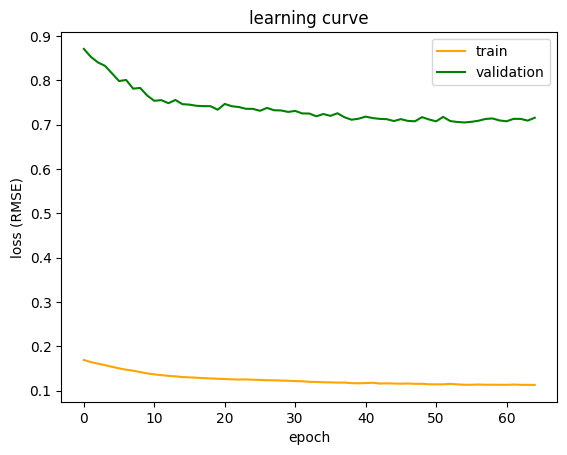

In [56]:
# rmses = scaler.inverse_transform(rmses)
# val_rmses = scaler.inverse_transform(val_rmses)

print("trainscores: " + str(trainscores))
print("testscores: " + str(testscores))
print("xt shape: " + str(x_t.shape))
print("xt: " + str(x_t[s][0]) )

# rmses = np.matrix(rmses)
# val_rmses = np.matrix(val_rmses)
#
# print(rmses.shape)
#
# rmse_avg = np.mean(rmses, axis=0).transpose()
# val_rmse_avg = np.mean(val_rmses, axis=0).transpose()
#
# print(rmse_avg.shape)
#
# rmse_std = np.std(rmses, axis=0).transpose()
# val_rmse_std = np.std(val_rmses, axis=0).transpose()
#
sigma = 1
skip = 3
#
# rmse_std_high = rmse_avg + rmse_std * sigma
# rmse_std_low = rmse_avg - rmse_std * sigma
# val_rmse_std_high = val_rmse_avg + val_rmse_std * sigma
# val_rmse_std_low = val_rmse_avg - val_rmse_std * sigma


# print(val_rmses)

# plt.plot(rmse_avg[skip:], label='train', color='orange')
# plt.plot(val_rmse_avg[skip:], label='validation', color='green')
# plt.plot(rmse_std_high[skip:], label='train std', linestyle='dashed', color='orange')
# plt.plot(rmse_std_low[skip:], label='_nolegend_', linestyle='dashed', color='orange')
# plt.plot(val_rmse_std_high[skip:], label='validation std', linestyle='dashed', color='green')
# plt.plot(val_rmse_std_low[skip:], label='_nolegend_', linestyle='dashed', color='green')
plt.plot(rmses[0][skip:], label='train', color='orange')
plt.plot(val_rmses[0][skip:], label='validation', color='green')
plt.title("learning curve")
plt.xlabel('epoch')
plt.ylabel('loss (RMSE)')
plt.legend(['train', 'validation', 'train_std', 'validation_std'], loc='upper right')
plt.show()


53/53 [==============================] - 0s 9ms/step


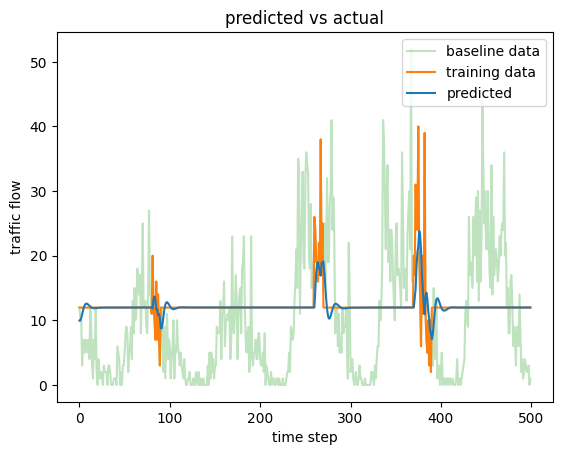

In [67]:
start = 0
end = 500

blue = '#1f77b4'
orange = '#ff7f0e'
green = '#2ca02c'

# y_predicted = model.predict(x_test[s])
# y_pred = scalers[s].inverse_transform(y_predicted.reshape(-1,1))
# y_testt = scalers[s].inverse_transform(y_test[s].reshape(-1,1))
# plt.plot(y_testt[start:end], label='actual', color=orange)
# plt.plot(y_pred[start:end], label='predicted', color=blue)


y_predicted = model.predict(x_t[s])

y_pred = scalers[s].inverse_transform(y_predicted.reshape(-1,1))
y_broken = scalers[s].inverse_transform(y_t[s].reshape(-1,1))
y_actual = scalers[s].inverse_transform(y_train[s].reshape(-1,1))

plt.plot(y_actual[start:end], label='baseline data', alpha=0.3, color=green)
plt.plot(y_broken[start:end], label='training data', color=orange)
plt.plot(y_pred[start:end], label='predicted', color=blue)



# print(x_t[s])

# if shuffle:
    # l = len(y_predicted)
    # y1 = y_train.append(y_val).append(y_test)
    # y2 = y_train.append(y_val).append(y_test)
    # y_predicted, y_test = unshuffle_arrays(y_predicted, y_test, permutations[0])


plt.title("predicted vs actual")
plt.xlabel('time step')
plt.ylabel('traffic flow')
plt.legend(loc='upper right')
plt.show()

# print(x_train[0])


In [32]:
# sequence_drop = [5.937290703361259, 6.050255907588749, 6.113564393383473, 6.300986722461655, 6.306093783352975, 6.859348969027009, 6.425697389114244, 6.240484308133876, 6.4600056638554655, 6.46977843684363, 6.281919620840296, 6.425109767102989, 6.51481501083175, 6.33793144660578, 7.880060735156781, 11.660277875047855, 11.063649335792908, 7.419221222670605, 8.717067946557489]
remove_amounts = np.arange(0.0, 0.96, 0.05)

sequence_drop_s0 = [5.80275512333168, 6.097074039240171, 6.118148666724612, 6.138588157838037, 6.096692465094835, 6.147706809717529, 6.283660852507075, 6.318140090568146, 6.3330610615123994, 6.2887496825848475, 7.904956764473474, 6.499192069917341, 6.360463804026401, 9.159791759261122, 6.6706346903503535, 7.076429790541205, 7.197807768056538, 7.869420648871733, 9.065270828199019, 9.529965726389672]
sequence_drop_s0_2 = [5.923651939144846, 6.035728002472713, 6.1791228654829835, 6.139826990484982, 6.167036502114471, 6.180019359072112, 6.064523755903508, 6.354595843553823, 6.50349913792068, 6.274009976445937, 7.457652026070844, 6.449679928502428, 6.537263032230999, 6.730683428683406, 6.489970766991194, 6.879670540922892, 7.275912532737945, 9.623438339045531, 9.384346531674423, 12.000172337139487]
sequence_drop_s1 = [4.875872976280148, 5.143962666105632, 5.0838097413964585, 5.65066811056198, 5.1282870548706, 5.3173337054231276, 5.443969201077721, 5.393986466860632, 5.448244382845988, 7.659485884235299, 6.947602702956976, 6.20468774228587, 6.115641241350505, 6.212406288178979, 6.549801015556122, 12.139879305183468, 9.175091734250653, 10.250541539304296, 11.535433549255881, 10.653783889430848]
sequence_drop_s74 = [3.7221515605535225, 3.7340011230247576, 3.7974154118214134, 3.7112173160816666, 3.88104731405838, 3.933756457717744, 3.864645466250647, 3.9988883698808046, 3.990665283846373, 4.141691249990172, 4.439314691779694, 4.735377287973522, 5.833886038764987, 4.928929295965234, 5.089023481024762, 4.8467277760084855, 6.558761617820929, 7.0201756131234125, 7.258137491014169, 8.020731036005929]
sequence_drop_s83 = [11.763828022859963, 11.975925286638745, 13.742332332311863, 13.0809138623422, 13.869753133003494, 15.068792241983155, 13.791254152371465, 14.45959638332699, 14.827251843292231, 17.451267694208838, 15.356626909737491, 16.104144932469932, 17.015516603923274, 34.465443578079146, 17.18452884374821, 37.26628279523855, 29.020140490046824, 36.563308611177305, 46.677586242048406, 49.61189957524125]
sequence_drop_s53 = [1.9601925521881938, 2.020939591816061, 2.006307928427115, 2.050999056528009, 2.0073075443646298, 2.065658859701579, 2.06486024839247, 2.0960430111880455, 2.044588638797325, 2.012620304948946, 2.018626481026951, 2.0399702302588794, 2.1709825960694165, 2.2123251007335587, 2.2046677798685272, 2.2900379098747417, 2.395509925873509, 2.275559665284925, 2.3422822412544297, 2.6850651387564426]

sequence_interpolation_s0 = [5.884398454724488, 5.893290210135884, 5.87991387844399, 5.93462353035117, 6.008400899349778, 6.098383739489963, 6.091886183628113, 6.186951920715532, 6.035041031627119, 6.213717222452649, 6.249146686296364, 6.2527202070611905, 6.358993455839185, 6.413530471994709, 6.315528279962114, 6.5055583889961035, 6.435025055606525, 6.455177000967018, 7.122407485830768, 6.639018064120929]
sequence_interpolation_s1 = [4.871627125346794, 4.941789736833946, 4.921620802942332, 5.206568830312809, 5.083339654511282, 4.986913735639498, 5.020321963352723, 5.156132131046169, 5.2206601310277865, 5.138029301094313, 5.124236872959302, 5.354731258588208, 5.408003520035872, 5.407733976788683, 5.469827998007299, 5.553496396650799, 5.571383461579939, 5.473769672825028, 5.734925204621436, 5.8060326771469155]
sequence_interpolation_s74 = [3.8032629349423863, 3.7420758990895377, 3.8355009962201456, 3.778715777429209, 3.939023163590731, 3.8847965506738102, 3.84781598249823, 3.9422318461177213, 3.867131126949886, 3.9551565881559667, 3.997152056181426, 4.066342956386271, 4.021078757438838, 4.107093508441207, 4.039793719851648, 4.402521988288497, 3.928151366431319, 4.096776455905323, 4.429006476087079, 4.925733965782364]
sequence_interpolation_s83 = [12.01431197201737, 12.138943487612803, 12.02198801359841, 11.981315604375906, 12.434393060007348, 12.221547713196921, 12.883468823121564, 12.915009848824074, 12.718239044948788, 13.110348461471649, 12.929430082924094, 12.83617771947542, 13.579335791832161, 13.270188461905027, 13.589674561247673, 13.824754143682194, 14.717910391965408, 14.174584038272297, 27.48873675199042, 18.85758050477042]
sequence_interpolation_s83_2 = [12.882407258688817, 11.959815901391147, 11.512118693228693, 12.065793960407017, 11.976386755828267, 12.458275040653126, 12.116538546615741, 12.709313052520772, 12.250473535699557, 13.238265718084127, 13.041635587976488, 12.894024829626147, 13.504156549694192, 13.159818244129994, 13.476683073955437, 14.397115309780396, 14.00146961371816, 14.143463084545017, 19.687809810673432, 17.299935808761656]
sequence_interpolation_s53 = [1.976015813300577, 1.995083989122585, 2.0682575271090573, 1.968418814546169, 1.9911221398494905, 1.9486896234028594, 1.9615192221503792, 1.9523721870408932, 2.1047428735090015, 1.9890740713590414, 2.0795572681197543, 2.0857605338134078, 1.9803188487814047, 2.0550556300936726, 2.1733254564322078, 2.153777431423768, 2.1321826672657243, 2.0452416140019416, 2.3075599283028687, 2.0445853537984884]

sequence_zero_s0 = [5.934568758521251, 6.039277001188321, 6.072149123289692, 6.075973408218182, 6.131611981291466, 6.279242710142609, 6.061097328583546, 6.222486422851454, 6.292696373500031, 6.22758849633677, 6.172963397342614, 6.344095689395306, 6.411802320541025, 6.87741220017679, 6.40915742020267, 6.65223040954923, 6.693940805894252, 6.415419592735293, 6.754215876477191, 7.934902211184823]
sequence_zero_s1 = [4.870665382178423, 4.851104866693063, 5.007325047178768, 5.061157752166415, 5.1628376629839146, 5.18325810671906, 5.442754504941543, 5.704676152915506, 5.384560751883984, 5.443426757771017, 5.464730879339136, 5.657299686167445, 5.57725072918384, 5.7740340544863855, 5.895260381700814, 5.8967271117273325, 5.808294440520677, 6.065327017920981, 7.098604675033318, 7.042806889853647]
sequence_zero_s74 = [3.7501975895526276, 3.8569362986201616, 3.784455234563927, 3.7626204281422915, 3.888340338764414, 3.915215922309156, 3.908051198986186, 4.05651360141626, 4.113309021568703, 3.8942212733068557, 4.075871784906566, 4.139459565676545, 4.163818567620394, 4.416709704893132, 4.259158585212286, 4.307640368765646, 4.559006474575634, 4.34689896213174, 4.23102868375386, 4.431878721845637]
sequence_zero_s83 = [11.615569083312632, 12.383828195912946, 13.09407334534341, 13.652670434404305, 13.420305153298807, 14.3592085530798, 15.111862492352786, 13.844080471965137, 15.236562252005278, 15.213406103349103, 15.987705559541704, 15.302727717465432, 15.547545836261705, 18.60296043717583, 15.805739711572127, 15.963183562632537, 16.479623765080802, 18.311799285673494, 22.502464453908544, 33.37886036984645]
sequence_zero_s53 = [2.0405011451505315, 2.0288463788631708, 1.9803709720163245, 1.9713006841329015, 1.987509365262264, 1.9531280242905726, 1.9754746839823163, 1.9665594876082482, 2.0048075686230944, 1.9649829359954676, 2.0166859301898197, 2.0662925829061516, 2.032719983205272, 2.0788681670554507, 2.0647584038514397, 2.0476448717286377, 2.023554826485609, 2.156801227783687, 2.2320154527437284, 2.0126828373935868]


drops = [sequence_drop_s0_2, sequence_drop_s1, sequence_drop_s74, sequence_drop_s53]
interpolations = [sequence_interpolation_s0, sequence_interpolation_s1, sequence_interpolation_s74, sequence_interpolation_s53]
zeros = [sequence_zero_s0, sequence_zero_s1, sequence_zero_s74,  sequence_zero_s53]

sequence_drop = np.mean(drops, axis=0)
sequence_interpolation = np.mean(interpolations, axis=0)
sequence_zero = np.mean(zeros, axis=0)
sequence_drop_std = np.std(drops, axis=0)
sequence_interpolation_std = np.std(interpolations, axis=0)
sequence_zero_std = np.std(zeros, axis=0)

baseline_num = np.mean([sequence_drop[0], sequence_interpolation[0], sequence_zero[0]])
baseline = np.repeat(baseline_num, len(sequence_drop))

20


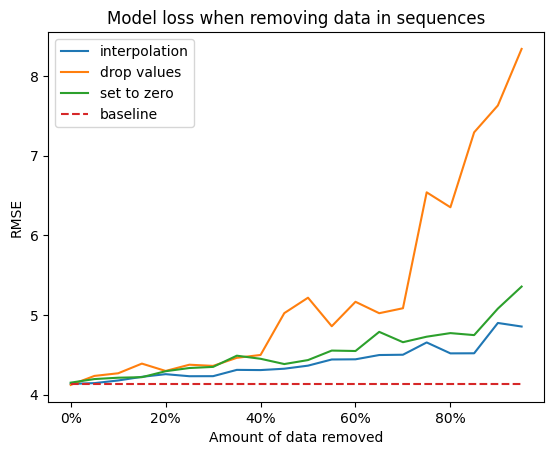

In [33]:
# plot testscores
# print(testscores)
print(len(remove_amounts))
plt.plot(remove_amounts * 100, sequence_interpolation, label="interpolation")
# plt.plot(remove_amounts * 100, sequence_interpolation + sequence_interpolation_std, label="interpolation std", linestyle='dashed')
plt.plot(remove_amounts * 100, sequence_drop, label="drop values")
# plt.plot(remove_amounts * 100, sequence_drop + sequence_drop_std, label="drop values std", linestyle='dashed')
plt.plot(remove_amounts * 100, sequence_zero, label="set to zero")
plt.plot(remove_amounts * 100, baseline, label="baseline", linestyle='dashed')
plt.title("Model loss when removing data in sequences")
plt.xlabel('Amount of data removed')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.ylabel('RMSE')
plt.legend()
plt.show()



